<a href="https://colab.research.google.com/github/hellojinwoo/Openintro_in_Python/blob/master/Code_Optimization_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Backtesting Algorithm through a Simple Example 
- __Author__: 박진우
- __Current Version__: 3.0
- __작성목적__: Mean reversion 방식으로 Futures Calendar Spread Trading을 백테스팅 할 때, 속도를 최대한 줄이기 위해 looping을 사용치 않는 방향으로 이 코드를 작성함.
- __비고__:
    - 1. 본 예제에 목적에 충실하기 위해 트레인 데이터/벨리데이션 데이터를 나누지 않음 
    - 2. 구글코랩에서 지금 버전까지 오기 위해 정운님과 나눈 커멘트 내역을 살펴보면 어떻게 발전하였는지 더 자세히 알 수 있음 

### Table of Contents

- [__Step 01. Loading raw data__](#Step-01.-Loading-raw-data)
- [__Step 02. Contango Scenario__](#Step-02.-Contango-Scenario)
- [__Step 03. Back-wardation Scenario__](#Step-03.-Back-wardation-Scenario)
- [__Step 04. Both Scenarios Considered__](#Step-04.-Both-Scenarios-Considered)

In [ ]:
# 라이브러리 임포팅하기
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import copy

# 파이썬 경고 끄기
import warnings
warnings.filterwarnings(action='ignore')

__hyper-parameter setting__

In [ ]:
# 1) trading fee
trading_fee = 0.001

# OKEX의 제 1종 코인(BTC,ETH 등)관련 분기별 선물은 이미 시장에 있는 호가를 Take할 때 거래액의 0.05%를 수수료 지불함. 
# 포지션 들어갈 때 Long position, Short position 각각 1번, 팔 때도 동일하게 각각 1번이므로, 총 4번 거래가 이루어짐. 그래서 전체금액의 0.05% * 4 = 전체금액의 0.2% 가 trading fee
# 하지만 현재 우리 코드상에서는 trading_fee = 0.1% 로 처리해야 하는데 이는 스프레드를 계산할 때, 전체금액으로 (Far+Near)를 사용하고 있기 때문이다. 
# 예시)
# Far 70 Near 60 → Far 65 Near 65 를 생각해보면
# 수익금: (70-65) + (-(60-65)) - trading_fee = 5+5 - (70+60+65+65) * 0.05% = 10 - 0.13 = 9.87
# 수익률 = 9.87/130 = 0.0759 = 7.59%
#       = (70-60)/(70+60) - (70+60+65+65)*0.0005/(70+60) = 10/130 - 0.13/130 = 0.0769 - 0.001 = 0.0759
# Assumption: position_in & position_out 할 때 Long position + Short position 거래액의 합이 변하지 않는다
# Source: https://www.okex.com/fees.html

## __Step 01. Loading raw data__
- 스프레드 데이터 로드 및 이해하기

In [ ]:
# 드라이브에 접근할 수 있도록 아래 코드 입력
# 출처: http://growthj.link/python-%EA%B5%AC%EA%B8%80-colab%EC%9C%BC%EB%A1%9C-pd-read_csv-%ED%99%9C%EC%9A%A9%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95/
from google.colab import drive
# drive.mount('/content/drive')
drive.mount('/content/drive')
raw_data_df = pd.read_csv("/content/drive/MyDrive/quant/falcon/Sliding window/raw_data.csv", index_col=0)

In [ ]:
raw_data_df = pd.read_csv("new_raw_data.csv", index_col=0)
print(f"raw_data_df.shape: {raw_data_df.shape}")
print("-" * 50)
print(f"데이터 기간: {raw_data_df.index[0]} ~ {raw_data_df.index[-1]}")
print("-" * 50)
print("   raw_data_df.head(3)    ")
display(raw_data_df.head(3))

raw_data_df.shape: (3000, 1)

--------------------------------------------------

데이터 기간: 2018-05-29 13:00:00 ~ 2018-10-04 01:00:00

--------------------------------------------------

   raw_data_df.head(3)    


,spread
2018-05-29 13:00:00,0.004526
2018-05-29 14:00:00,0.002701
2018-05-29 15:00:00,0.004159


In [ ]:
# 데이터프레임의 인덱스가 단순히 string인지, datetime.datetime인지 확인
type(raw_data_df.index[0])

str

In [ ]:
# str이므로 datetime으로 변경
raw_data_df.index = pd.to_datetime(raw_data_df.index)

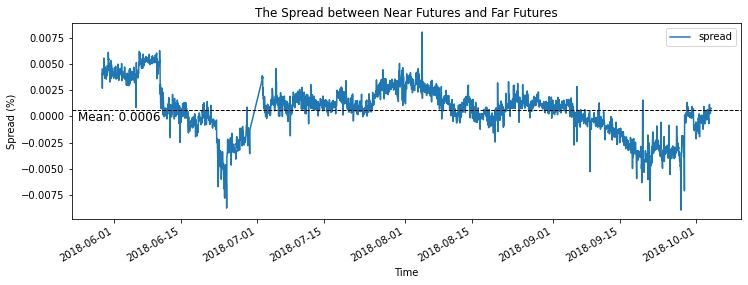

In [ ]:
ax = raw_data_df.plot(figsize = (12,4), title = 'The Spread between Near Futures and Far Futures')

# x_axis, y_axis에 제목 표시하기
ax.set_ylabel('Spread (%)');
ax.set_xlabel('Time');

# horizontal line으로 mean표시하기
ax.axhline(raw_data_df.loc[:,'spread'].mean(), color='k', linestyle='dashed', linewidth=1)

# help source: https://stackoverflow.com/a/52961228/8846998
min_ylim, max_ylim = ax.get_ylim()
ylim_diff = (max_ylim - min_ylim)
min_xlim, max_xlim = ax.get_xlim()
xlim_diff = (max_xlim - min_xlim)
ax.text((min_xlim + xlim_diff*0.01), (min_ylim + ylim_diff * 0.5), f"Mean: {raw_data_df.loc[:,'spread'].mean():.4f}", fontsize=12); 

In [ ]:
mean_df = raw_data_df.loc[:,'spread'].mean()
std_df = raw_data_df.loc[:,'spread'].std()

print(f"Spread 평균: {raw_data_df.loc[:,'spread'].mean():.4f}, 표준편차: {raw_data_df.loc[:,'spread'].std():.4f}")

Spread 평균: 0.0006, 표준편차: 0.0023


## __Step 02. Contango Scenario__
- 콘탱고 상황에서 수익파악하기

__1. 포지션 진입 구간, 포지션 청산 구간 파악하기__

In [ ]:
# buy_threshold, sell_threshold에 따라서 action (buy, sell) 정하기
# 코드 도움: https://stackoverflow.com/a/39111919/8846998

# 원본 데이터 보존을 위해 deepcopy하기
con_df = copy.deepcopy(raw_data_df) # con_df = contango_df

k = 1  #std에 몇배를 해서 mean과 더할지 결정하는 상수. 예시에서는 k=1 활용

col         = 'spread'
conditions  = [con_df.loc[:,col] >= mean_df+(k*std_df), # mean+std값보다 스프레드가 커질 시, 콘탱고 과열되었다고 판단 --> 포지션 진입 구간
               con_df.loc[:,col] <= mean_df] # 스프레드 평균(mean)보다 같거나 작을시 시장 정상화라고 판단 --> 포지션 청산 구간 
 
choices     = ["buy", "sell"]
    
con_df.loc[:,"action"] = np.select(conditions, choices, default=np.nan)
display(con_df.head(3))
print(f"contango_df.shape: {con_df.shape}")

,spread,action
2018-05-29 13:00:00,0.004526,buy
2018-05-29 14:00:00,0.002701,nan
2018-05-29 15:00:00,0.004159,buy


contango_df.shape: (3000, 2)


__2. 포지션 진입 시점, 청산 시점 파악하기__
- 진입 구간, 청산 구간의 맨 처음 시간 (time point)를 진입 시점, 청산시점으로 잡는다.

In [ ]:
# 아무런 액션 없는 nan 로우들 제거하기
filtered_con_df = con_df[(con_df.loc[:,'action'] == 'buy') | (con_df.loc[:,'action'] == 'sell')]
display(filtered_con_df.head(3))
print(f"filtered_contango_df.shape: {filtered_con_df.shape}")

,spread,action
2018-05-29 13:00:00,0.004526,buy
2018-05-29 15:00:00,0.004159,buy
2018-05-29 16:00:00,0.003947,buy


filtered_contango_df.shape: (1783, 2)


In [ ]:
# 연속된 buy, sell 중 처음의 buy, sell만 남기고 제거하기. (처음 buy, sell 신호가 나왔을 때, 실행하므로 나머지 연속된 buy,sell은 무의미함)
con_buy_sell_df = filtered_con_df[filtered_con_df['action'].shift(1) != filtered_con_df['action']]
print("     buy_sell_df.head(3)")
display(con_buy_sell_df.head(3))

print("-" * 35)
print()
print("      con_buy_sell_df.tail(3)")
display(con_buy_sell_df.tail(3))
print(f"con_buy_sell_df.shape: {con_buy_sell_df.shape}")

     buy_sell_df.head(3)


,spread,action
2018-05-29 13:00:00,0.004526,buy
2018-06-11 06:00:00,0.000171,sell
2018-07-02 01:00:00,0.003498,buy


-----------------------------------



      con_buy_sell_df.tail(3)


,spread,action
2018-08-24 20:00:00,0.000467,sell
2018-08-25 15:00:00,0.003052,buy
2018-08-26 22:00:00,0.000483,sell


con_buy_sell_df.shape: (22, 2)


__체크해야할 점 2가지__
- __1) action 칼럼의 맨 처음 행동이 sell인가?__ 
  - __만약 그렇다면 포지션에 노출되어 있지도 않은데, 포지션을 나갈 수 없으므로 이 sell 행동은 제거한다.__
  - __해당되지 않음__
  

- __2) action 칼럼의 맨 마지막 행동이 buy인가?__
    - __만약 그렇다면, 해당 블럭의 맨 마지막 시간의 포지션으로 포지션 청산해야 함.__
    - __해당되지 않음__

__3. 진입, 청산 시점 정리하기__
- __시점을 시간(datetime), 인덱스(index number) 별로 각각 파악해야 한다.__

In [ ]:
# 포지션 진입 시점을 datetime 으로 파악
con_buy_time_array = np.array([x for x in con_buy_sell_df.index[::2]]) # [::2]는 0,2,4,6,...식으로 indexing을 하라는 뜻이다.
con_buy_time_array

array([Timestamp('2018-05-29 13:00:00'), Timestamp('2018-07-02 01:00:00'),
       Timestamp('2018-07-04 22:00:00'), Timestamp('2018-07-12 06:00:00'),
       Timestamp('2018-07-19 15:00:00'), Timestamp('2018-07-26 00:00:00'),
       Timestamp('2018-08-14 04:00:00'), Timestamp('2018-08-20 09:00:00'),
       Timestamp('2018-08-22 16:00:00'), Timestamp('2018-08-23 17:00:00'),
       Timestamp('2018-08-25 15:00:00')], dtype=object)

In [ ]:
# 포지션 진입 시점을 raw_data_df의 인덱스로 파악
con_buy_index_array = raw_data_df.index.searchsorted(con_buy_time_array)
con_buy_index_array

array([   0,  744,  813,  989, 1166, 1319, 1779, 1928, 1983, 2008, 2054],
      dtype=int64)

In [ ]:
# 포지션 청산 시점을 datetime 으로 파악
con_sell_time_array = np.array([x for x in con_buy_sell_df.index[1::2]]) # [1::2]는 1,3,5,7,...식으로 indexing을 하라는 뜻이다.
con_sell_time_array

array([Timestamp('2018-06-11 06:00:00'), Timestamp('2018-07-02 16:00:00'),
       Timestamp('2018-07-05 12:00:00'), Timestamp('2018-07-13 19:00:00'),
       Timestamp('2018-07-20 05:00:00'), Timestamp('2018-08-08 16:00:00'),
       Timestamp('2018-08-14 15:00:00'), Timestamp('2018-08-20 11:00:00'),
       Timestamp('2018-08-23 00:00:00'), Timestamp('2018-08-24 20:00:00'),
       Timestamp('2018-08-26 22:00:00')], dtype=object)

In [ ]:
# 포지션 청산 시점을 raw_data_df의 인덱스로 파악
con_sell_index_array = raw_data_df.index.searchsorted(con_sell_time_array)
con_sell_index_array

array([ 305,  759,  827, 1026, 1180, 1647, 1790, 1930, 1991, 2035, 2085],
      dtype=int64)

In [ ]:
# datetime으로 파악한 포지션 진입 + 청산 시점 
con_buy_sell_time_array = np.concatenate((con_buy_time_array, con_sell_time_array))
con_buy_sell_time_array.sort()
con_buy_sell_time_array

array([Timestamp('2018-05-29 13:00:00'), Timestamp('2018-06-11 06:00:00'),
       Timestamp('2018-07-02 01:00:00'), Timestamp('2018-07-02 16:00:00'),
       Timestamp('2018-07-04 22:00:00'), Timestamp('2018-07-05 12:00:00'),
       Timestamp('2018-07-12 06:00:00'), Timestamp('2018-07-13 19:00:00'),
       Timestamp('2018-07-19 15:00:00'), Timestamp('2018-07-20 05:00:00'),
       Timestamp('2018-07-26 00:00:00'), Timestamp('2018-08-08 16:00:00'),
       Timestamp('2018-08-14 04:00:00'), Timestamp('2018-08-14 15:00:00'),
       Timestamp('2018-08-20 09:00:00'), Timestamp('2018-08-20 11:00:00'),
       Timestamp('2018-08-22 16:00:00'), Timestamp('2018-08-23 00:00:00'),
       Timestamp('2018-08-23 17:00:00'), Timestamp('2018-08-24 20:00:00'),
       Timestamp('2018-08-25 15:00:00'), Timestamp('2018-08-26 22:00:00')],
      dtype=object)

In [ ]:
# raw_data_df의 인덱스로 파악한 포지션 진입 + 청산시점
con_buy_sell_index_array = raw_data_df.index.searchsorted(con_buy_sell_time_array)
con_buy_sell_index_array

array([   0,  305,  744,  759,  813,  827,  989, 1026, 1166, 1180, 1319,
       1647, 1779, 1790, 1928, 1930, 1983, 1991, 2008, 2035, 2054, 2085],
      dtype=int64)

__4. 포지션 들고 있을 때 포트폴리오 밸류 변화 파악하기__

In [ ]:
# 위의 con_buy_sell_index_array (진입시점 ~ 청산시점) 중간에 비는 숫자 index들을 np.arange로 채움
# np.arange는 start_point는 포함하고, end_point는 포함하지 않음 --> 즉 포지션 진입 시점의 index는 포함, 포지션 청산 시점의 index는 불포함.
con_position_hold_index_array = np.hstack([np.arange(i1, i2) for i1, i2 in zip(con_buy_sell_index_array[::2], con_buy_sell_index_array[1::2])])

# 포지션 진입시점 ~ 포지션 청산 시점 바로 전까지의 스프레드를 모아놓은 데이터프레임을 만든다
con_position_hold_df = raw_data_df.iloc[con_position_hold_index_array]

# 확인
print(" con_position_hold_df.head(3)")
display(con_position_hold_df.head(3))
print("-" * 25)
print()
print(" con_position_hold_df.tail(3)")
display(con_position_hold_df.tail(3))
print(f"con_position_hold_df.shape: {con_position_hold_df.shape}")

 con_position_hold_df.head(3)


,spread
2018-05-29 13:00:00,0.004526
2018-05-29 14:00:00,0.002701
2018-05-29 15:00:00,0.004159


-------------------------



 con_position_hold_df.tail(3)


,spread
2018-08-26 19:00:00,0.000975
2018-08-26 20:00:00,0.001165
2018-08-26 21:00:00,0.000688


con_position_hold_df.shape: (792, 1)


- __위에 tail에서 확인할 수 있듯이 맨 마지막 sales 시간인 `2018-08-26 22:00:00'은 데이터프레임에서 제외되어 있음 (이는 np.arange가 오른쪽 경계를 포함하지 않기 때문)__
- __따라서 `position_hold_index_array` 및 `position_hold_df`를 사용할 때, 포지션 청산 시점에서의 스프레드는 고려하지 않아도 되므로 편함__

__5-1. 비실현수익 계산__

In [ ]:
con_position_hold_df.loc[con_buy_time_array,'buy_spread'] = con_position_hold_df.loc[con_buy_time_array,'spread']
con_position_hold_df.fillna(method = 'ffill', inplace = True)
con_position_hold_df.loc[:,'unrealized_profit'] = (con_position_hold_df.loc[:,'buy_spread'] - con_position_hold_df.loc[:,'spread']) - trading_fee

print(" "*12 +"con_position_hold_df.head(3)")
con_position_hold_df.head(3)

            con_position_hold_df.head(3)


,spread,buy_spread,unrealized_profit
2018-05-29 13:00:00,0.004526,0.004526,-0.001000
2018-05-29 14:00:00,0.002701,0.004526,0.000825
2018-05-29 15:00:00,0.004159,0.004526,-0.000633


In [ ]:
con_unrealized_profit_series = con_position_hold_df.loc[:,'unrealized_profit']

__5-2. 실현수익 계산__

In [ ]:
# buy_sell_df기준: action = 'sell'인 로우에서 (buy_spread - sell_spread)의 차이를 계산할 수 있도록 하나의 row를 shift시킨다.
con_buy_sell_df.loc[:,'shifted_spread'] = con_buy_sell_df.loc[:,'spread'].shift(1) 

# Action = 'buy'인 로우는 수익과 상관없으므로 제거한다
con_sell_df = con_buy_sell_df[con_buy_sell_df.loc[:,'action'] == 'sell']  # sell_df의 shifted_spread는 이제 buy_spread를 의미함

# realized_profit을 계산한다
con_sell_df.loc[:,'realized_profit'] = (con_sell_df.loc[:,'shifted_spread'] - con_sell_df.loc[:,'spread']) - trading_fee

print(" "*20+"con_sell_df.head(3)")
display(con_sell_df.head(3))
print(f"con_sell_df.shape: {con_sell_df.shape}")

                    con_sell_df.head(3)


,spread,action,shifted_spread,realized_profit
2018-06-11 06:00:00,0.000171,sell,0.004526,0.003355
2018-07-02 16:00:00,0.000332,sell,0.003498,0.002166
2018-07-05 12:00:00,0.000051,sell,0.004583,0.003532


con_sell_df.shape: (11, 4)


In [ ]:
con_realized_profit_series = con_sell_df.loc[:,'realized_profit']

## __Step 03. Back-wardation Scenario__
- 백워데이션 상황에서 수익파악하기

__1. 포지션 진입 구간, 포지션 청산 구간 파악하기__

In [ ]:
# buy_threshold, sell_threshold에 따라서 action (buy, sell) 정하기
# 코드 도움: https://stackoverflow.com/a/39111919/8846998
back_df = copy.deepcopy(raw_data_df) # con_df = contango_df

k = 1  #std에 몇배를 해서 mean과 더할지 결정하는 상수. 예시에서는 k=1 활용

col         = 'spread'
conditions  = [back_df.loc[:,col] <= (mean_df-(k*std_df)), # 스프레드가 (mean_df-(k*std_df))보다 작다면 백워데이션 과열되었다고 판단 --> 포지션 진입 구간
               back_df.loc[:,col] >= mean_df] # 스프레드 평균(mean)보다 같거나 클시 시장 정상화라고 판단 --> 포지션 청산 구간 
 
choices     = ["buy", "sell"]
    
back_df.loc[:,"action"] = np.select(conditions, choices, default=np.nan)
display(back_df.head(3))
print(f"back_df.shape: {back_df.shape}")

,spread,action
2018-05-29 13:00:00,0.004526,sell
2018-05-29 14:00:00,0.002701,sell
2018-05-29 15:00:00,0.004159,sell


back_df.shape: (3000, 2)


In [ ]:
back_df.action.value_counts()

sell    1656
nan     1044
buy      300
Name: action, dtype: int64

__2. 포지션 진입 시점, 청산 시점 파악하기__
- 진입 구간, 청산 구간의 맨 처음 시간 (time point)를 진입 시점, 청산시점으로 잡는다.

In [ ]:
# 아무런 액션 없는 nan 로우들 제거하기
filtered_back_df = back_df[(back_df.loc[:,'action'] == 'buy') | (back_df.loc[:,'action'] == 'sell')]
display(filtered_back_df.head(3))
print(f"filtered_back_df.shape: {filtered_back_df.shape}")

,spread,action
2018-05-29 13:00:00,0.004526,sell
2018-05-29 14:00:00,0.002701,sell
2018-05-29 15:00:00,0.004159,sell


filtered_back_df.shape: (1956, 2)


In [ ]:
# 연속된 buy, sell 중 처음의 buy, sell만 남기고 제거하기. (처음 buy, sell 신호가 나왔을 때, 실행하므로 나머지 연속된 buy,sell은 무의미함)
back_buy_sell_df = filtered_back_df[filtered_back_df['action'].shift(1) != filtered_back_df['action']]
print("     back_buy_sell_df.head(3)")
display(back_buy_sell_df.head(3))

print("-" * 35)
print()
print("      back_buy_sell_df.tail(3)")
display(back_buy_sell_df.tail(3))
print(f"back_buy_sell_df.shape: {back_buy_sell_df.shape}")

     back_buy_sell_df.head(3)


,spread,action
2018-05-29 13:00:00,0.004526,sell
2018-06-22 17:00:00,-0.003409,buy
2018-06-28 21:00:00,0.000902,sell


-----------------------------------



      back_buy_sell_df.tail(3)


,spread,action
2018-09-19 18:00:00,0.001185,sell
2018-09-19 20:00:00,-0.004460,buy
2018-09-29 01:00:00,0.000720,sell


back_buy_sell_df.shape: (11, 2)


__체크해야할 점 2가지__
- __1) action 칼럼의 맨 처음 행동이 sell인가? -> <font color='red'>해당함</font>__
  - __만약 그렇다면 포지션에 노출되어 있지도 않은데, 포지션을 나갈 수 없으므로 이 sell 행동은 제거한다.__

In [ ]:
back_buy_sell_df.drop(back_buy_sell_df.index[0], inplace=True)
back_buy_sell_df.head(3)

,spread,action
2018-06-22 17:00:00,-0.003409,buy
2018-06-28 21:00:00,0.000902,sell
2018-06-29 10:00:00,-0.003333,buy


- __2) action 칼럼의 맨 마지막 행동이 buy인가?__
    - __만약 그렇다면, 해당 블럭의 맨 마지막 시간의 포지션으로 포지션 청산해야 함.__

__3. 진입, 청산 시점 정리하기__

In [ ]:
# 포지션 진입 시점을 datetime으로 파악
back_buy_time_array = np.array([x for x in back_buy_sell_df.index[::2]]) # [::2]는 0,2,4,6,...식으로 indexing을 하라는 뜻이다.
back_buy_time_array

array([Timestamp('2018-06-22 17:00:00'), Timestamp('2018-06-29 10:00:00'),
       Timestamp('2018-09-08 17:00:00'), Timestamp('2018-09-16 05:00:00'),
       Timestamp('2018-09-19 20:00:00')], dtype=object)

In [ ]:
# 포지션 진입 시점을 raw_data_df의 인덱스로 파악
back_buy_index_array = raw_data_df.index.searchsorted(back_buy_time_array)
back_buy_index_array

array([ 580,  741, 2392, 2572, 2659], dtype=int64)

In [ ]:
# 포지션 청산 시점을 datetime으로 파악
back_sell_time_array = np.array([x for x in back_buy_sell_df.index[1::2]]) # [1::2]는 1,3,5,7,...식으로 indexing을 하라는 뜻이다.
back_sell_time_array

array([Timestamp('2018-06-28 21:00:00'), Timestamp('2018-07-02 01:00:00'),
       Timestamp('2018-09-10 11:00:00'), Timestamp('2018-09-19 18:00:00'),
       Timestamp('2018-09-29 01:00:00')], dtype=object)

In [ ]:
# 포지션 청산 시점을 raw_data_df의 인덱스로 파악
back_sell_index_array = raw_data_df.index.searchsorted(back_sell_time_array)
back_sell_index_array

array([ 728,  744, 2434, 2657, 2879], dtype=int64)

In [ ]:
# datetime으로 파악한 포지션 진입 + 청산 시점 
back_buy_sell_time_array = np.concatenate((back_buy_time_array, back_sell_time_array))
back_buy_sell_time_array.sort()
back_buy_sell_time_array

array([Timestamp('2018-06-22 17:00:00'), Timestamp('2018-06-28 21:00:00'),
       Timestamp('2018-06-29 10:00:00'), Timestamp('2018-07-02 01:00:00'),
       Timestamp('2018-09-08 17:00:00'), Timestamp('2018-09-10 11:00:00'),
       Timestamp('2018-09-16 05:00:00'), Timestamp('2018-09-19 18:00:00'),
       Timestamp('2018-09-19 20:00:00'), Timestamp('2018-09-29 01:00:00')],
      dtype=object)

In [ ]:
# raw_data_df의 인덱스로 파악한 포지션 진입 + 청산시점
back_buy_sell_index_array = raw_data_df.index.searchsorted(back_buy_sell_time_array)
back_buy_sell_index_array

array([ 580,  728,  741,  744, 2392, 2434, 2572, 2657, 2659, 2879],
      dtype=int64)

__4. 포지션 들고 있을 때 포트폴리오 밸류 변화 파악하기__

In [ ]:
# 위의 buy_sell_index_array (진입시점 ~ 청산시점) 중간에 비는 숫자 index들을 np.arange로 채움
# np.arange는 start_point는 포함하고, end_point는 포함하지 않음 --> 즉 포지션 진입 시점의 index는 포함, 포지션 청산 시점의 index는 불포함.
back_position_hold_index_array = np.hstack([np.arange(i1, i2) for i1, i2 in zip(back_buy_sell_index_array[::2], back_buy_sell_index_array[1::2])])

# 포지션 진입시점 ~ 포지션 청산 시점 바로 전까지의 스프레드를 모아놓은 데이터프레임을 만든다
back_position_hold_df = raw_data_df.iloc[back_position_hold_index_array]

# 확인
print(" back_position_hold_df.head(3)")
display(back_position_hold_df.head(3))
print("-" * 25)
print()
print(" back_position_hold_df.tail(3)")
display(back_position_hold_df.tail(3))
print(f"back_position_hold_df.shape: {back_position_hold_df.shape}")

 back_position_hold_df.head(3)


,spread
2018-06-22 17:00:00,-0.003409
2018-06-22 18:00:00,-0.004002
2018-06-22 19:00:00,-0.004646


-------------------------



 back_position_hold_df.tail(3)


,spread
2018-09-28 22:00:00,-0.000092
2018-09-28 23:00:00,0.000324
2018-09-29 00:00:00,0.000446


back_position_hold_df.shape: (498, 1)


- __위에 tail에서 확인할 수 있듯이 맨 마지막 sales 시간인 `2018-09-29 01:00:00'은 데이터프레임에서 제외되어 있음 (이는 np.arange가 오른쪽 경계를 포함하지 않기 때문)__
- __따라서 `back_position_hold_index_array` 및 `back_position_hold_df`를 사용할 때, 포지션 청산 시점에서의 스프레드는 고려하지 않아도 되므로 편함__

__5-1. 비실현수익 계산__

In [ ]:
back_position_hold_df.loc[back_buy_time_array,'buy_spread'] = back_position_hold_df.loc[back_buy_time_array,'spread']
back_position_hold_df.fillna(method = 'ffill', inplace = True)

# 백워데이션 상황에서는 차월물-당월물 spread가 음수일 때 포지션에 노출되므로, (포지션 진입 스프레드 - 포지션 청산 스프레드)의 결과값에 -를 씌워야함
# e.g.) 포지션 진입 스프레드: -3.5%, 포지션 청산 스프레드: 1% --> -3.5% - 1% = -4.5%. 수익을 보았는데도 -4.5%로 계산되면 안되므로 결과값에 - 씌우기
back_position_hold_df.loc[:,'unrealized_profit'] = -(back_position_hold_df.loc[:,'buy_spread'] - back_position_hold_df.loc[:,'spread']) - trading_fee

print(" "*12 +"back_position_hold_df.head(3)")
back_position_hold_df.head(3)

            back_position_hold_df.head(3)


,spread,buy_spread,unrealized_profit
2018-06-22 17:00:00,-0.003409,-0.003409,-0.001000
2018-06-22 18:00:00,-0.004002,-0.003409,-0.001593
2018-06-22 19:00:00,-0.004646,-0.003409,-0.002237


In [ ]:
back_unrealized_profit_series = back_position_hold_df.loc[:,'unrealized_profit']

__5-2. 실현수익 계산__

In [ ]:
# buy_sell_df기준: action = 'sell'인 로우에서 (buy_spread - sell_spread)의 차이를 계산할 수 있도록 하나의 row를 shift시킨다.
back_buy_sell_df.loc[:,'shifted_spread'] = back_buy_sell_df.loc[:,'spread'].shift(1) 

# Action = 'buy'인 로우는 수익과 상관없으므로 제거한다
back_sell_df = back_buy_sell_df[back_buy_sell_df.loc[:,'action'] == 'sell']  # sell_df의 shifted_spread는 이제 buy_spread를 의미함

# realized_profit을 계산한다
back_sell_df.loc[:,'realized_profit'] = -(back_sell_df.loc[:,'shifted_spread'] - back_sell_df.loc[:,'spread']) - trading_fee

print(" "*20+"back_sell_df.head(3)")
display(back_sell_df.head(3))
print(f"back_sell_df.shape: {back_sell_df.shape}")

                    back_sell_df.head(3)


,spread,action,shifted_spread,realized_profit
2018-06-28 21:00:00,0.000902,sell,-0.003409,0.003311
2018-07-02 01:00:00,0.003498,sell,-0.003333,0.005831
2018-09-10 11:00:00,0.000610,sell,-0.005282,0.004892


back_sell_df.shape: (5, 4)


In [ ]:
back_realized_profit_series = back_sell_df.loc[:,'realized_profit']

## Step 04. Both Scenarios Considered
- __콘탱고, 백워데이션 양쪽 시나리오 모두에서 트레이딩 했을 때의 투자성과 확인__

__1. Total Profit 계산하기__

In [ ]:
# realized_profit
realized_profit_series = pd.concat([con_realized_profit_series, back_realized_profit_series])
realized_profit_series.sort_index(inplace=True)

# unrealized_profit
unrealized_profit_series = pd.concat([con_unrealized_profit_series, back_unrealized_profit_series])
unrealized_profit_series.sort_index(inplace=True)

# 데이터프레임으로 만들기
merged_df = pd.DataFrame(data = {'realized':(realized_profit_series+1).cumprod(), 'unrealized': (unrealized_profit_series+1)},
                         index = raw_data_df.index)
merged_df.head(3)

,realized,unrealized
2018-05-29 13:00:00,NaN,0.999000
2018-05-29 14:00:00,NaN,1.000825
2018-05-29 15:00:00,NaN,0.999367


In [ ]:
### Nan 부분 채우기
# 1) realized_profit 부분
merged_df.loc[:,'realized'].fillna(method='ffill', inplace=True)
merged_df.loc[:,'realized'].fillna(1, inplace=True) # 아직도 realized_profit 없는 곳은 거래가 없으므로 포트폴리오 벨류에 변화가 없음

# 2) unrealized_profit 부분
merged_df.loc[:,'unrealized'].fillna(1, inplace=True) # unrealized_profit에서의 빈 칸은 포지션을 들고 있지 않다는 것을 뜻함 
merged_df

### total_profit 계산하기
merged_df.loc[:,'total'] = merged_df.loc[:,'realized'] * merged_df.loc[:,'unrealized']

merged_df.head(3)

,realized,unrealized,total
2018-05-29 13:00:00,1.0,0.999000,0.999000
2018-05-29 14:00:00,1.0,1.000825,1.000825
2018-05-29 15:00:00,1.0,0.999367,0.999367


__2. 시각화__

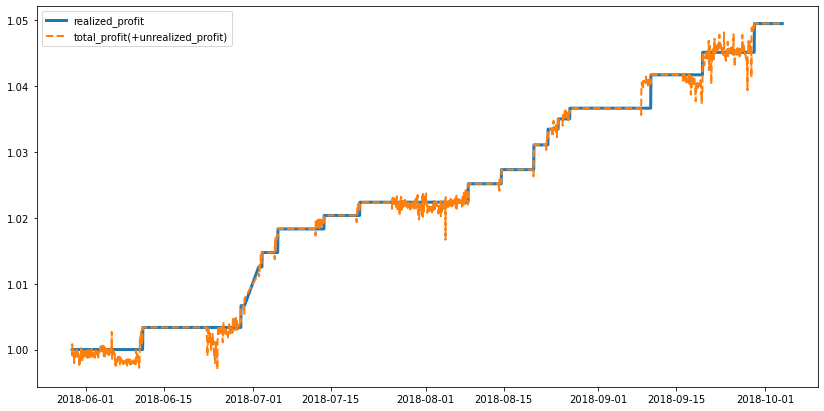

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(merged_df.loc[:,'realized'], linewidth = 3)
plt.plot(merged_df.loc[:,'total'], linestyle= '--', linewidth = 2)
plt.legend(['realized_profit','total_profit(+unrealized_profit)'])

__3.라인 그래프 중 대각선 분석__
- 2018년 7월 1일 근처에서 왜 대각선이 보이는지 분석 (다른 곳에서는 다 지면과 수직으로 그래프가 변동하는데 여기서만 대각선 이동이 발생해서 이상함)

<AxesSubplot:>

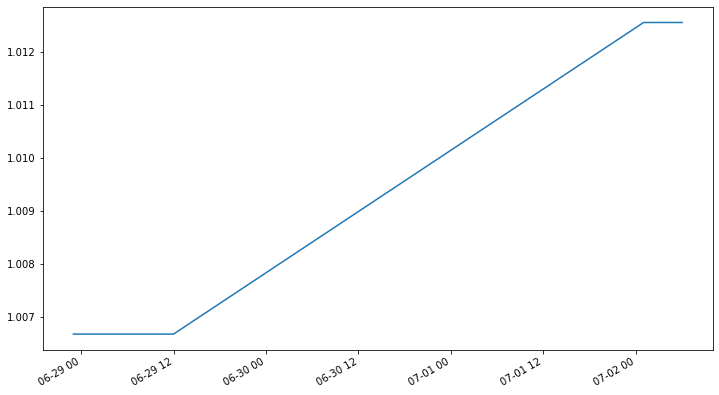

In [ ]:
merged_df.loc[:,'realized'].iloc[730:750].plot(figsize=(12,7))

- 2018년 6월 29일 ~ 7월 2일 사이에 대각선 그래프 생기는 것 확인. 기초자료(`back_raw_data_df`)에서 그 이유를 파악해보자

In [ ]:
merged_df.loc[:,'realized'].iloc[740:750]

2018-06-29 09:00:00    1.006677
2018-06-29 10:00:00    1.006677
2018-06-29 11:00:00    1.006677
2018-06-29 12:00:00    1.006677
2018-07-02 01:00:00    1.012547
2018-07-02 02:00:00    1.012547
2018-07-02 03:00:00    1.012547
2018-07-02 04:00:00    1.012547
2018-07-02 05:00:00    1.012547
2018-07-02 06:00:00    1.012547
Name: realized, dtype: float64

- 6월 29일에서 바로 7월 2일로 넘어가기 때문임을 확인. 왜 6월 30일, 7월 1일 자료가 없는 걸까?
- 가장 기초 자료인 `raw_data_df` 확인

In [ ]:
raw_data_df.loc[datetime(2018,6,29,11):datetime(2018,7,2,2),:]

,spread
2018-06-29 11:00:00,-0.003569
2018-06-29 12:00:00,-0.001259
2018-07-02 01:00:00,0.003498
2018-07-02 02:00:00,0.003908


- 원래 기초자료에서도 중간 자료가 비어있음을 확인. 코딩에는 문제 없음